## 问题定义

对待求解问题的数学描述如下：
![Equation](./resource/equation.png)

其中，$u$为待求解物理量，$x,y$为空间坐标，$t$为时间，$c=1$为波速，$q$为源项

当介质情况比较复杂时（$c$在不同位置值不同），上述具有相当的求解难度。

本示例的待求解问题定义如下：
![Problem](./resource/problem_define.png)

横纵长度均为2km，在深度（$y$）为1km，横坐标（$x$）为1km的位置有一个源点，该源点建模为Ricker wavlet，峰值频率$f_0=15Hz$。上半部分的波速为1.0km/s，下半部分的波速为2.0km/s。

Ricker wavlet如下

![RickerWavlet](./resource/RickerWavlet.png)

### 边界条件

地震波通常会传递到无穷远的地方，因此在有限元中，通常采用Absorbing BC或Perfectly Matched Layer模拟无限远，避免边界反射

本问题采用开放边界条件

![BC](./resource/boundary.png)


### 求解目标

给定150ms-300ms的波场数据，要求求解300ms-1000ms的解


## 求解

In [1]:
import os
import sys

# optional
# set appropriate GPU in case of multi-GPU machine
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
# 必要的符号运算
from sympy import Symbol, Eq, Abs, Function, Number, sin
import numpy as np

import modulus.sym

# 超参数
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra import to_absolute_path, instantiate_arch, ModulusConfig
from modulus.sym.hydra.utils import compose

# 求解器
from modulus.sym.solver import Solver

# domain
from modulus.sym.domain import Domain

# 几何物体
from modulus.sym.geometry.primitives_2d import Rectangle

# 约束
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
    PointwiseConstraint
)

# validator
from modulus.sym.domain.validator import PointwiseValidator

# inferencer
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.key import Key

# Equation
# 导入抽象基类
from modulus.sym.eq.pdes.wave_equation import WaveEquation
from modulus.sym.eq.pde import PDE

# post process
from modulus.sym.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)

# 绘图
import matplotlib
from PIL import Image

In [3]:
cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 50000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 1000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: true
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
  

### 定义必要组件

#### PDE

In [4]:
we = WaveEquation(u="u", c="c", dim=2, time=True)

#### Model

In [5]:
# 输入为空间坐标和时间坐标
# 输出为u
wave_net = instantiate_arch(
    input_keys=[Key("x"), Key("y"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)
print(wave_net)

# 输入为空间坐标
# 输出为波速c
speed_net = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("c")],
    cfg=cfg.arch.fully_connected,
)

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=3, out_features=256, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=256, out_features=256, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)


#### Geo

In [6]:
# 定义求解区域
# 本问题中，x范围为[0, 2]，y范围为[0, 2]，t范围为[0.15s, 1s]

x, y, t = Symbol("x"), Symbol("y"), Symbol("t")

dLen = 2  # km
rec = Rectangle((0, 0), (dLen, dLen))

time_length = 1
time_range = {t: (0.15, time_length)}

#### Domain

在Domain中定义约束以及训练所需的各种组件

In [7]:
# make domain
domain = Domain()

边界条件

本问题中的边界条件需要计算复杂的PDE，因此加入到node中集中处理比较好，为此，需要额外自定义PDE

In [8]:
class OpenBoundary(PDE):
    """
    Open boundary condition for wave problems
    Ref: http://hplgit.github.io/wavebc/doc/pub/._wavebc_cyborg002.html

    Parameters
    ==========
    u : str
        The dependent variable.
    c : float, Sympy Symbol/Expr, str
        Wave speed coefficient. If `c` is a str then it is
        converted to Sympy Function of form 'c(x,y,z,t)'.
        If 'c' is a Sympy Symbol or Expression then this
        is substituted into the equation.
    dim : int
        Dimension of the wave equation (1, 2, or 3). Default is 2.
    time : bool
        If time-dependent equations or not. Default is True.
    """

    name = "OpenBoundary"

    def __init__(self, u="u", c="c", dim=3, time=True):
        # set params
        self.u = u
        self.dim = dim
        self.time = time

        # coordinates
        x, y, z = Symbol("x"), Symbol("y"), Symbol("z")

        # normal
        normal_x, normal_y, normal_z = (
            Symbol("normal_x"),
            Symbol("normal_y"),
            Symbol("normal_z"),
        )

        # time
        t = Symbol("t")

        # make input variables
        input_variables = {"x": x, "y": y, "z": z, "t": t}
        if self.dim == 1:
            input_variables.pop("y")
            input_variables.pop("z")
        elif self.dim == 2:
            input_variables.pop("z")
        if not self.time:
            input_variables.pop("t")

        # Scalar function
        assert type(u) == str, "u needs to be string"
        u = Function(u)(*input_variables)

        # wave speed coefficient
        if type(c) is str:
            c = Function(c)(*input_variables)
        elif type(c) in [float, int]:
            c = Number(c)

        # set equations
        self.equations = {}
        self.equations["open_boundary"] = (
            u.diff(t)
            + normal_x * c * u.diff(x)
            + normal_y * c * u.diff(y)
            + normal_z * c * u.diff(z)
        )

In [9]:
# boundary condition
ob = OpenBoundary(u="u", c="c", dim=2, time=True)

In [10]:
nodes = (
        we.make_nodes(detach_names=["c"])  # wave PDE
        + ob.make_nodes(detach_names=["c"])  # 开放边界条件
        + [
            wave_net.make_node(name="wave_network"),  # 模型1：预测u
            speed_net.make_node(name="speed_network"),  # 模型2：预测c
        ]
    )

In [11]:
# 边界约束项
edges = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"open_boundary": 0},
    batch_size=1024,
    lambda_weighting={"open_boundary": 0.01 * time_length},
    parameterization=time_range,
)
domain.add_constraint(edges, "Edges")

#### 必要的数据项

按照定义，在$y\in[0, 1]$范围内$c=1$，在$y\in[1, 2]$范围内$c=2$

In [12]:
# define target velocity model
# 2.0 km/s at the bottom and 1.0 km/s at the top using tanh function
mesh_x, mesh_y = np.meshgrid(
    np.linspace(0, 2, 512), np.linspace(0, 2, 512), indexing="ij"
)
wave_speed_invar = {}
wave_speed_invar["x"] = np.expand_dims(mesh_x.flatten(), axis=-1)
wave_speed_invar["y"] = np.expand_dims(mesh_y.flatten(), axis=-1)
wave_speed_outvar = {}

# 注意
# 这里使用的不是硬切分，即强行指定[0, 1]c=1, [1, 2]c=2
# 而是引入了一个高倍率的tanh进行计算
# 从而得到一个更smooth的界面
# 提高收敛效率
wave_speed_outvar["c"] = np.tanh(80 * (wave_speed_invar["y"] - 1.0)) / 2 + 1.5

In [13]:
# 基于上述的定义的c预测约束

velocity = PointwiseConstraint.from_numpy(
    nodes=nodes, invar=wave_speed_invar, outvar=wave_speed_outvar, batch_size=1024
)
domain.add_constraint(velocity, "Velocity")

#### 初始条件

In [14]:
# 从高精度数据中加载切片
# 用于验证和构造初始条件
def read_wf_data(time, dLen):
    file_path = "./openfoam/Training_data"
    if not os.path.exists(to_absolute_path(file_path)):
        warnings.warn(
            f"Directory {file_path} does not exist. Cannot continue. Please download the additional files from NGC https://catalog.ngc.nvidia.com/orgs/nvidia/teams/modulus/resources/modulus_sym_examples_supplemental_materials"
        )
        sys.exit()
    wf_filename = to_absolute_path(f"openfoam/Training_data/wf_{int(time):04d}ms.npz")
    wave = np.load(wf_filename)["arr_0"].astype(np.float32)
    mesh_y, mesh_x = np.meshgrid(
        np.linspace(0, dLen, wave.shape[0]),
        np.linspace(0, dLen, wave.shape[1]),
        indexing="ij",
    )
    invar = {}
    invar["x"] = np.expand_dims(mesh_y.astype(np.float32).flatten(), axis=-1)
    invar["y"] = np.expand_dims(mesh_x.astype(np.float32).flatten(), axis=-1)
    invar["t"] = np.full_like(invar["x"], time * 0.001)
    outvar = {}
    outvar["u"] = np.expand_dims(wave.flatten(), axis=-1)
    return invar, outvar

In [15]:
# 使用已知时间段：[150ms, 300ms]的4个切片数据作为初始条件
batch_size = 1024
for i, ms in enumerate(np.linspace(150, 300, 4)):
    # 加载当前时刻的切片数据
    timestep_invar, timestep_outvar = read_wf_data(ms, dLen)
    # 设置样本权重
    lambda_weighting = {}
    lambda_weighting["u"] = np.full_like(timestep_invar["x"], 10.0 / batch_size)
    # 定义监督项
    timestep = PointwiseConstraint.from_numpy(
        nodes,
        timestep_invar,
        timestep_outvar,
        batch_size,
        lambda_weighting=lambda_weighting,
    )
    domain.add_constraint(timestep, f"BC{i:04d}")

#### PDE 约束
内部满足PDE约束

In [16]:
# add interior constraint
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"wave_equation": 0},
    batch_size=4096,
    bounds={x: (0, dLen), y: (0, dLen)},
    lambda_weighting={"wave_equation": 0.0001},
    parameterization=time_range,
)
domain.add_constraint(interior, "Interior")

验证器以及其他必要组件

In [17]:
class WavePlotter(ValidatorPlotter):
    "Define custom validator plotting class"

    def __call__(self, invar, true_outvar, pred_outvar):
        # only plot x,y dimensions
        # 确保仅绘制x和y，排除t
        invar = {k: v for k, v in invar.items() if k in ["x", "y"]}
        fs = super().__call__(invar, true_outvar, pred_outvar)
        return fs

In [18]:
# 使用350ms到950ms的13个切片作为validator
for i, ms in enumerate(np.linspace(350, 950, 13)):
    val_invar, val_true_outvar = read_wf_data(ms, dLen)
    validator = PointwiseValidator(
        nodes=nodes,
        invar=val_invar,
        true_outvar=val_true_outvar,
        batch_size=1024,
        plotter=WavePlotter(),
    )
    domain.add_validator(validator, f"VAL_{i:04d}")
    
# 波速预测validator
validator = PointwiseValidator(
    nodes=nodes,
    invar=wave_speed_invar,
    true_outvar=wave_speed_outvar,
    batch_size=1024,
    plotter=WavePlotter(),
)
domain.add_validator(validator, "Velocity")

### 求解器以及求解

In [19]:
# 定义求解器
slv = Solver(cfg, domain)

手动加载日志系统

In [20]:
import logging
# logging.getLogger().addHandler(logging.StreamHandler())
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

启动求解

In [21]:
slv.solve()

2024-02-18 07:50:55,178 - modulus.sym.trainer - WARNING - Installed PyTorch version 2.2.0a0+81ea7a4 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
2024-02-18 07:50:55,188 - modulus.sym.trainer - INFO - attempting to restore from: /workspace/02_2D_Wave/outputs
2024-02-18 07:50:55,207 - modulus.sym.trainer - INFO - Success loading optimizer: /workspace/02_2D_Wave/outputs/optim_checkpoint.0.pth
2024-02-18 07:50:55,213 - modulus.sym.trainer - INFO - Success loading model: /workspace/02_2D_Wave/outputs/speed_network.0.pth
2024-02-18 07:50:55,219 - modulus.sym.trainer - INFO - Success loading model: /workspace/02_2D_Wave/outputs/wave_network.0.pth
2024-02-18 07:50:56,774 - modulus.sym.trainer - INFO - [step:          0] record constraint batch time:  9.310e-02s
2024-02-18 07:51:30,842 - modulus.sym.trainer - INFO - [step:          0] record validators time:  3.407e+01s
2024-02-18 07:51:30,902 - modulus.sym.trainer - INFO - [step:          0] saved c

2024-02-18 07:56:01,562 - modulus.sym.trainer - INFO - [step:       4900] loss:  6.673e+00, time/iteration:  2.424e+01 ms
2024-02-18 07:56:37,696 - modulus.sym.trainer - INFO - [step:       5000] record validators time:  3.317e+01s
2024-02-18 07:56:37,747 - modulus.sym.trainer - INFO - [step:       5000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 07:56:37,748 - modulus.sym.trainer - INFO - [step:       5000] loss:  6.968e+00, time/iteration:  3.618e+02 ms
2024-02-18 07:56:40,168 - modulus.sym.trainer - INFO - [step:       5100] loss:  5.699e+00, time/iteration:  2.418e+01 ms
2024-02-18 07:56:42,608 - modulus.sym.trainer - INFO - [step:       5200] loss:  7.723e+00, time/iteration:  2.439e+01 ms
2024-02-18 07:56:45,007 - modulus.sym.trainer - INFO - [step:       5300] loss:  7.191e+00, time/iteration:  2.398e+01 ms
2024-02-18 07:56:47,453 - modulus.sym.trainer - INFO - [step:       5400] loss:  8.062e+00, time/iteration:  2.445e+01 ms
2024-02-18 07:56:49,872 - modulus.

2024-02-18 08:01:32,339 - modulus.sym.trainer - INFO - [step:      10200] loss:  3.355e+00, time/iteration:  2.400e+01 ms
2024-02-18 08:01:34,783 - modulus.sym.trainer - INFO - [step:      10300] loss:  2.639e+00, time/iteration:  2.443e+01 ms
2024-02-18 08:01:37,181 - modulus.sym.trainer - INFO - [step:      10400] loss:  3.524e+00, time/iteration:  2.397e+01 ms
2024-02-18 08:01:39,615 - modulus.sym.trainer - INFO - [step:      10500] loss:  7.180e+00, time/iteration:  2.433e+01 ms
2024-02-18 08:01:42,022 - modulus.sym.trainer - INFO - [step:      10600] loss:  6.758e+00, time/iteration:  2.406e+01 ms
2024-02-18 08:01:44,437 - modulus.sym.trainer - INFO - [step:      10700] loss:  5.207e+00, time/iteration:  2.413e+01 ms
2024-02-18 08:01:46,875 - modulus.sym.trainer - INFO - [step:      10800] loss:  6.993e+00, time/iteration:  2.437e+01 ms
2024-02-18 08:01:49,274 - modulus.sym.trainer - INFO - [step:      10900] loss:  6.825e+00, time/iteration:  2.398e+01 ms
2024-02-18 08:02:24,826 

2024-02-18 08:06:37,632 - modulus.sym.trainer - INFO - [step:      15800] loss:  7.769e+00, time/iteration:  2.409e+01 ms
2024-02-18 08:06:40,054 - modulus.sym.trainer - INFO - [step:      15900] loss:  4.884e+00, time/iteration:  2.421e+01 ms
2024-02-18 08:06:43,099 - modulus.sym.trainer - INFO - [step:      16000] record constraint batch time:  1.058e-01s
2024-02-18 08:07:16,916 - modulus.sym.trainer - INFO - [step:      16000] record validators time:  3.382e+01s
2024-02-18 08:07:16,951 - modulus.sym.trainer - INFO - [step:      16000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 08:07:16,953 - modulus.sym.trainer - INFO - [step:      16000] loss:  3.859e+00, time/iteration:  3.690e+02 ms
2024-02-18 08:07:19,400 - modulus.sym.trainer - INFO - [step:      16100] loss:  5.482e+00, time/iteration:  2.445e+01 ms
2024-02-18 08:07:21,820 - modulus.sym.trainer - INFO - [step:      16200] loss:  4.098e+00, time/iteration:  2.419e+01 ms
2024-02-18 08:07:24,562 - modulus.sym.tr

2024-02-18 08:12:11,907 - modulus.sym.trainer - INFO - [step:      21100] loss:  5.940e+00, time/iteration:  2.430e+01 ms
2024-02-18 08:12:14,320 - modulus.sym.trainer - INFO - [step:      21200] loss:  7.917e+00, time/iteration:  2.410e+01 ms
2024-02-18 08:12:16,788 - modulus.sym.trainer - INFO - [step:      21300] loss:  8.314e+00, time/iteration:  2.467e+01 ms
2024-02-18 08:12:19,212 - modulus.sym.trainer - INFO - [step:      21400] loss:  9.475e+00, time/iteration:  2.422e+01 ms
2024-02-18 08:12:21,702 - modulus.sym.trainer - INFO - [step:      21500] loss:  5.976e+00, time/iteration:  2.488e+01 ms
2024-02-18 08:12:24,117 - modulus.sym.trainer - INFO - [step:      21600] loss:  9.467e+00, time/iteration:  2.414e+01 ms
2024-02-18 08:12:26,527 - modulus.sym.trainer - INFO - [step:      21700] loss:  9.286e+00, time/iteration:  2.409e+01 ms
2024-02-18 08:12:28,966 - modulus.sym.trainer - INFO - [step:      21800] loss:  9.727e+00, time/iteration:  2.437e+01 ms
2024-02-18 08:12:31,370 

2024-02-18 08:17:17,184 - modulus.sym.trainer - INFO - [step:      26600] loss:  2.538e+00, time/iteration:  2.418e+01 ms
2024-02-18 08:17:19,617 - modulus.sym.trainer - INFO - [step:      26700] loss:  2.515e+00, time/iteration:  2.432e+01 ms
2024-02-18 08:17:22,039 - modulus.sym.trainer - INFO - [step:      26800] loss:  9.703e+00, time/iteration:  2.420e+01 ms
2024-02-18 08:17:24,485 - modulus.sym.trainer - INFO - [step:      26900] loss:  2.985e+00, time/iteration:  2.445e+01 ms
2024-02-18 08:18:02,370 - modulus.sym.trainer - INFO - [step:      27000] record validators time:  3.491e+01s
2024-02-18 08:18:02,402 - modulus.sym.trainer - INFO - [step:      27000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 08:18:02,404 - modulus.sym.trainer - INFO - [step:      27000] loss:  2.009e+00, time/iteration:  3.792e+02 ms
2024-02-18 08:18:04,868 - modulus.sym.trainer - INFO - [step:      27100] loss:  1.873e+00, time/iteration:  2.463e+01 ms
2024-02-18 08:18:07,295 - modulus.

2024-02-18 08:22:52,654 - modulus.sym.trainer - INFO - [step:      32000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 08:22:52,656 - modulus.sym.trainer - INFO - [step:      32000] loss:  3.087e+00, time/iteration:  3.575e+02 ms
2024-02-18 08:22:55,097 - modulus.sym.trainer - INFO - [step:      32100] loss:  5.793e+00, time/iteration:  2.439e+01 ms
2024-02-18 08:22:57,520 - modulus.sym.trainer - INFO - [step:      32200] loss:  6.089e+00, time/iteration:  2.422e+01 ms
2024-02-18 08:22:59,950 - modulus.sym.trainer - INFO - [step:      32300] loss:  3.142e+00, time/iteration:  2.429e+01 ms
2024-02-18 08:23:02,372 - modulus.sym.trainer - INFO - [step:      32400] loss:  4.585e+00, time/iteration:  2.421e+01 ms
2024-02-18 08:23:04,802 - modulus.sym.trainer - INFO - [step:      32500] loss:  3.076e+00, time/iteration:  2.428e+01 ms
2024-02-18 08:23:07,249 - modulus.sym.trainer - INFO - [step:      32600] loss:  3.312e+00, time/iteration:  2.445e+01 ms
2024-02-18 08:23:09,65

2024-02-18 08:28:00,695 - modulus.sym.trainer - INFO - [step:      37500] loss:  5.068e+00, time/iteration:  2.509e+01 ms
2024-02-18 08:28:03,185 - modulus.sym.trainer - INFO - [step:      37600] loss:  3.021e+00, time/iteration:  2.489e+01 ms
2024-02-18 08:28:05,721 - modulus.sym.trainer - INFO - [step:      37700] loss:  1.886e+00, time/iteration:  2.535e+01 ms
2024-02-18 08:28:08,223 - modulus.sym.trainer - INFO - [step:      37800] loss:  3.508e+00, time/iteration:  2.501e+01 ms
2024-02-18 08:28:10,734 - modulus.sym.trainer - INFO - [step:      37900] loss:  4.880e+00, time/iteration:  2.510e+01 ms
2024-02-18 08:28:13,750 - modulus.sym.trainer - INFO - [step:      38000] record constraint batch time:  1.018e-01s
2024-02-18 08:28:47,403 - modulus.sym.trainer - INFO - [step:      38000] record validators time:  3.365e+01s
2024-02-18 08:28:47,432 - modulus.sym.trainer - INFO - [step:      38000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 08:28:47,434 - modulus.sym.tr

2024-02-18 08:33:41,037 - modulus.sym.trainer - INFO - [step:      43000] record validators time:  3.611e+01s
2024-02-18 08:33:41,064 - modulus.sym.trainer - INFO - [step:      43000] saved checkpoint to /workspace/02_2D_Wave/outputs
2024-02-18 08:33:41,066 - modulus.sym.trainer - INFO - [step:      43000] loss:  3.165e+00, time/iteration:  3.904e+02 ms
2024-02-18 08:33:43,534 - modulus.sym.trainer - INFO - [step:      43100] loss:  2.128e+00, time/iteration:  2.467e+01 ms
2024-02-18 08:33:45,972 - modulus.sym.trainer - INFO - [step:      43200] loss:  1.656e+00, time/iteration:  2.436e+01 ms
2024-02-18 08:33:48,419 - modulus.sym.trainer - INFO - [step:      43300] loss:  2.011e+00, time/iteration:  2.446e+01 ms
2024-02-18 08:33:50,858 - modulus.sym.trainer - INFO - [step:      43400] loss:  1.538e+00, time/iteration:  2.438e+01 ms
2024-02-18 08:33:53,306 - modulus.sym.trainer - INFO - [step:      43500] loss:  2.023e+00, time/iteration:  2.447e+01 ms
2024-02-18 08:33:55,737 - modulus.

2024-02-18 08:38:39,699 - modulus.sym.trainer - INFO - [step:      48300] loss:  1.412e+00, time/iteration:  2.422e+01 ms
2024-02-18 08:38:42,135 - modulus.sym.trainer - INFO - [step:      48400] loss:  1.022e+00, time/iteration:  2.435e+01 ms
2024-02-18 08:38:44,567 - modulus.sym.trainer - INFO - [step:      48500] loss:  2.141e+00, time/iteration:  2.431e+01 ms
2024-02-18 08:38:47,408 - modulus.sym.trainer - INFO - [step:      48600] loss:  9.952e-01, time/iteration:  2.838e+01 ms
2024-02-18 08:38:50,362 - modulus.sym.trainer - INFO - [step:      48700] loss:  1.095e+00, time/iteration:  2.953e+01 ms
2024-02-18 08:38:53,169 - modulus.sym.trainer - INFO - [step:      48800] loss:  2.955e+00, time/iteration:  2.805e+01 ms
2024-02-18 08:38:55,663 - modulus.sym.trainer - INFO - [step:      48900] loss:  9.728e-01, time/iteration:  2.493e+01 ms
2024-02-18 08:39:33,201 - modulus.sym.trainer - INFO - [step:      49000] record validators time:  3.458e+01s
2024-02-18 08:39:33,245 - modulus.sy

### 后处理以及可视化

对于jupyter，比较方便的方法是使用matplotlib

此外，还可以使用tensorboard以及Paraview

如果使用了PointwiseValidator则可以直接查看验证的结果。

time: 350.00ms


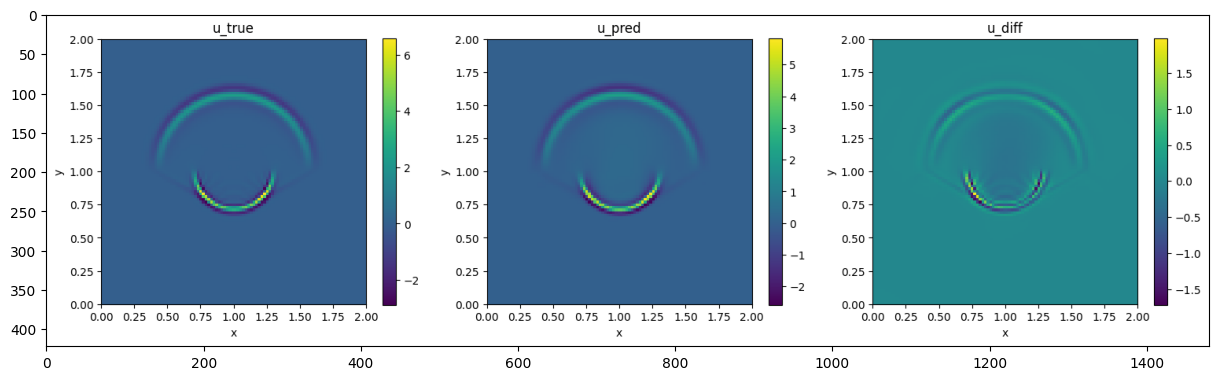

time: 550.00ms


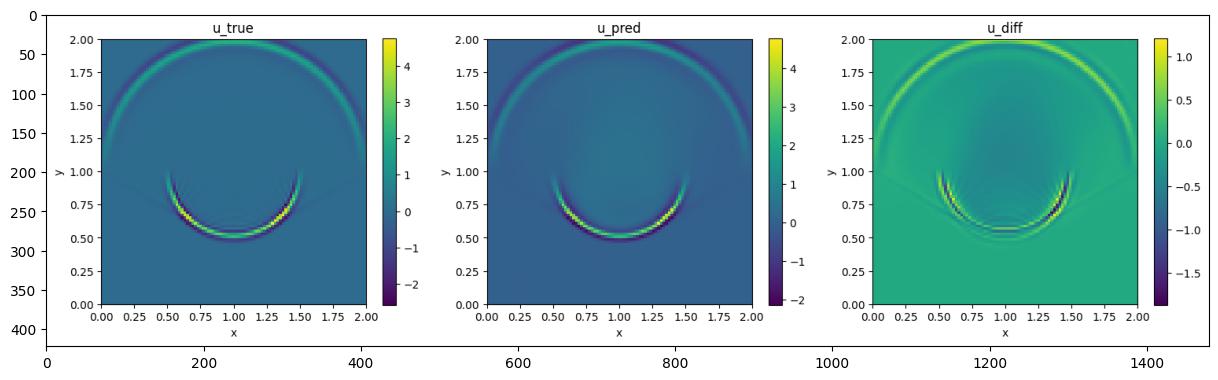

time: 750.00ms


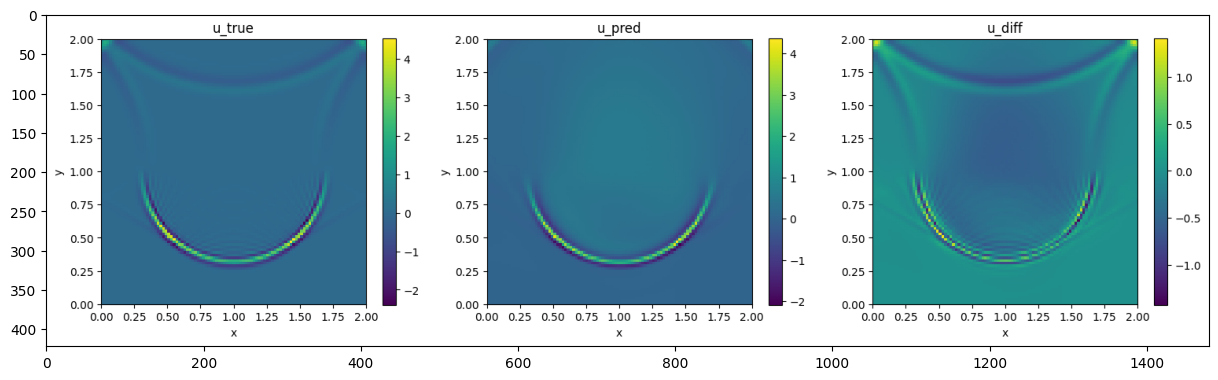

time: 950.00ms


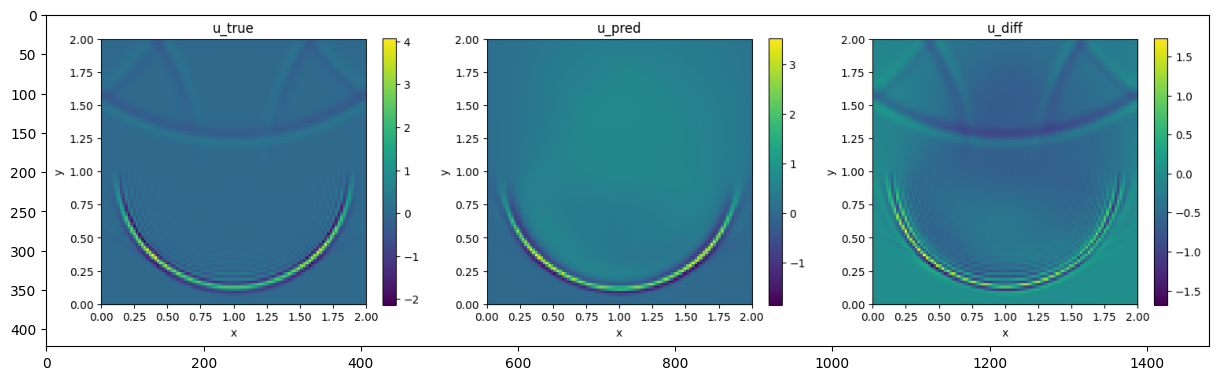

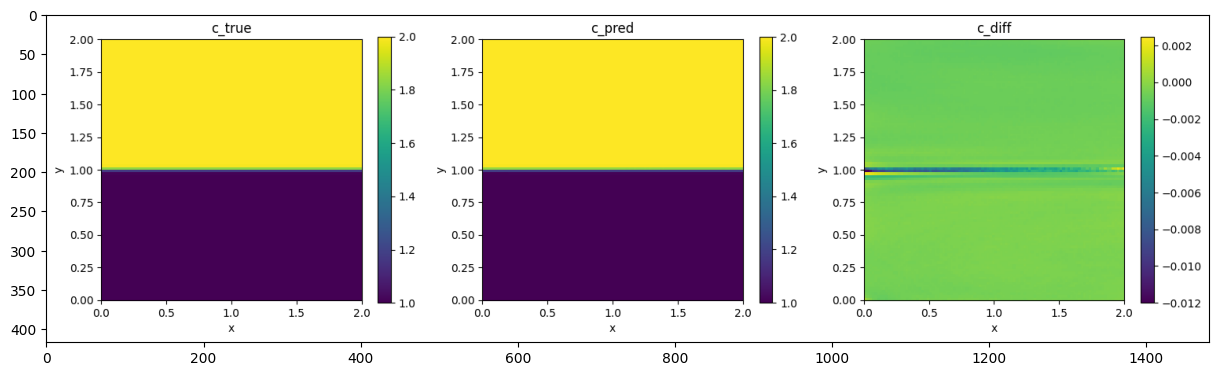

In [27]:
# 对于13个切片，展示四个
import matplotlib.pyplot as plt
for i, ms in enumerate(np.linspace(350, 950, 13)):
    if i % 4 == 0:
        print(f'time: {ms:.2f}ms')
        _ = plt.figure(figsize=(15, 15))
        img = Image.open(f'./outputs/validators/VAL_{i:0>4}_u.png')
        _ = plt.imshow(img)
        _ = plt.show(15,15);

# 波速
_ = plt.figure(figsize=(15, 15))
img = Image.open(f'./outputs/validators/Velocity_c.png')
_ = plt.imshow(img)
_ = plt.show(15,15);

可以看到，对反射的处理并不是非常优秀，这个可以通过改善训练参数来缓解。波速预测方面，误差已经很小了。